# Assemblytics Analysis

- Inputs: outputs from `DK_0911_nucmer_and_assemblytics_mapping`
- Programs: N/A
- Purpose: graphical representation of genomic variants.
- Notes: added function that automatically labels bar charts at the correct position above the bars (rather than hand-picking values by trial-and-error), included x-axis scientific notation flexibility, relocated titles, and streamlined font-sizing options.

**Assemblytics** was run with the following parameters:
* anchor of 8000 based on the TE size
* windows either being 10kp or 50kp

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from Bio import SeqIO
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from itertools import product
import colormap as cmaps

In [3]:
GENOME_VERSION = 'v032'

In [4]:
os.chdir('/home/gamran/genome_analysis/Warrior/Richard/scripts/')
%run 'DK_0911_contig_lengths.ipynb'

PWH_SIZE = getPwhSize()

GENOME = 'DK_0911_%s' % GENOME_VERSION

#define the input folder
ASSEMBLYTICS_FOLDER = '/home/gamran/genome_analysis/Warrior/Richard/output/nucmer_assemblytics/%s/Assemblytics/' % GENOME_VERSION
FIGURE_PATH = '/home/gamran/genome_analysis/Warrior/Richard/output/nucmer_assemblytics/%s/Assemblytics_figures/' % GENOME_VERSION

if not os.path.exists(FIGURE_PATH):
    os.mkdir(FIGURE_PATH)

Total number of haplotigs: 1176
Total haplotig length: 52126201

Total number of primary contigs: 94
Total primary contig length: 74427617

Total number of primary contigs with haplotigs: 86
Total primary contigs with haplotigs length: 73945211

Total number of primary contigs without haplotigs: 8
Total primary contigs without haplotigs length: 482406


In [5]:
os.chdir(ASSEMBLYTICS_FOLDER)

In [6]:
#get the folders and the pcontigs fasta files
_8kbp_folders = [x for x in os.listdir(ASSEMBLYTICS_FOLDER) if x.endswith('_8kbp')]
pcontig_fa = [x for x in os.listdir(ASSEMBLYTICS_FOLDER) if x.endswith('.fa') and '_pcontig' in x and 'h_ctgs' not in x]

In [7]:
# (total primary contigs) - (paired primary contigs)
len(pcontig_fa) - len(_8kbp_folders)

8

In [8]:
def return_contig_id(x):
    import re
    pattern = re.compile('_(pcontig_[0-9]*)')
    return pattern.search(x).groups()[0]

In [9]:
# make dataframe for 10kb windows
_8kbp_folders.sort()
Assemblytics_summary_df_list_10kb = []
#Assemblytics_summary_df_list_50kb = []
variation_types = ['Insertion', 'Deletion', 'Tandem_expansion', 'Tandem_contraction', 'Repeat_expansion', 'Repeat_contraction']
for folder in _8kbp_folders:
    #get the summary file
    summary_file_10kb = [x for x in os.listdir(os.path.abspath(folder)) \
                    if x.endswith('10kp.Assemblytics_structural_variants.summary.csv')][0]
    #summary_file_50kb = [x for x in os.listdir(os.path.abspath(folder)) \
              #      if x.endswith('_50kp.Assemblytics_structural_variants.summary.csv')][0]
    file_name_10kb = ''
    file_name_10kb = os.path.join(ASSEMBLYTICS_FOLDER, folder, summary_file_10kb)
    #file_name_50kb = ''
    #file_name_50kb = os.path.join(base_folder, folder, summary_file_50kb)
    #now convert summary file to a df usable file
    with open(file_name_10kb) as s_handle:
        out_handle = open(file_name_10kb.replace('.csv', '.df'), 'w')
        variation_type = ''
        for line in s_handle:
            if line.strip() == '':
                continue
            if 'Total' in line:
                continue
            line = line.strip('\n')
            if line in variation_types:
                variation_type = line
                next
            else:
                line = variation_type + ','+line
                print(line, file=out_handle)
        out_handle.close()
    #now read in the dataframe and reformat the indexes so it is useful later on
    #Multiindex column contig_id, numbers; Multiindex rows Type and size range
    contig = ''
    contig = return_contig_id(folder)
    #print('Reading in %s' % (contig))
    var_df = ''
    var_df = pd.read_csv(file_name_10kb.replace('.csv', '.df'), header=None, names=['Type', 'Size range', 'Count', 'Total bp'])
    if len(var_df) == 0: # some contigs might not have any variations called.
        continue
    index = pd.MultiIndex.from_tuples(list(zip(var_df['Type'],var_df['Size range'])), names=['Type', 'Size range'])
    var_df = var_df.set_index(index)
    var_df = var_df.iloc[:,2:] #subset the two remaining useful columns
    old_columns = list(var_df.columns)
    col_index = pd.MultiIndex.from_tuples(list(zip([contig, contig], old_columns)),names = ['contig_id','numbers'])
    var_df.columns = col_index
    Assemblytics_summary_df_list_10kb.append(var_df)
Assemblytics_summary_df_10kb = pd.concat(Assemblytics_summary_df_list_10kb, axis=1)

In [10]:
#make dataframe for 50kb windows
_8kbp_folders.sort()
Assemblytics_summary_df_list_50kb = []
variation_types = ['Insertion', 'Deletion', 'Tandem_expansion', 'Tandem_contraction', 'Repeat_expansion', 'Repeat_contraction']
for folder in _8kbp_folders:
    #get the summary file
    
    summary_file_50kb = [os.path.join(os.path.abspath(folder), x) for x in os.listdir(os.path.abspath(folder)) \
              if x.endswith('_50kp.Assemblytics_structural_variants.summary.csv')][0]
    file_name_50kb = ''
    file_name_50kb = os.path.join(ASSEMBLYTICS_FOLDER, folder, summary_file_50kb)
    #now convert summary file to a df usable file
    with open(summary_file_50kb) as s_handle:
        out_handle = open(file_name_50kb.replace('.csv', '.df'), 'w')
        variation_type = ''
        for line in s_handle:
            if line.strip() == '':
                continue
            if 'Total' in line:
                continue
            line = line.strip('\n')
            if line in variation_types:
                variation_type = line
                next
            else:
                line = variation_type + ','+line
                print(line, file=out_handle)
        out_handle.close()  
    #now read in the dataframe and reformat the indexes so it is useful later on
    #Multiindex column contig_id, numbers; Multiindex rows Type and size range
    contig = ''
    contig = return_contig_id(folder)
    #print('Reading in %s' % (contig))
    var_df = ''
    var_df = pd.read_csv(file_name_50kb.replace('.csv', '.df'), header=None, names=['Type', 'Size range', 'Count', 'Total bp'])
    if len(var_df) == 0: #some contigs might not have any variations called.
        continue
    index = pd.MultiIndex.from_tuples(list(zip(var_df['Type'],var_df['Size range'])), names=['Type', 'Size range'])
    var_df = var_df.set_index(index)
    var_df = var_df.iloc[:,2:] #subset the two remaining useful columns
    old_columns = list(var_df.columns)
    col_index = pd.MultiIndex.from_tuples(list(zip([contig, contig], old_columns)),names = ['contig_id','numbers'])
    var_df.columns = col_index
    Assemblytics_summary_df_list_50kb.append(var_df)
Assemblytics_summary_df_50kb = pd.concat(Assemblytics_summary_df_list_50kb, axis=1)

In [11]:
#save out the summary dataframes
Assemblytics_summary_df_50kb.to_csv(os.path.join(ASSEMBLYTICS_FOLDER, 'Assemblytics_summary_df_50kb.df'))
Assemblytics_summary_df_10kb.to_csv(os.path.join(ASSEMBLYTICS_FOLDER, 'Assemblytics_summary_df_10kb.df'))

In [12]:
Assemblytics_summary_df_10kb.unstack()

contig_id          pcontig_000                                           \
numbers                  Count                                 Total bp   
Size range             1-10 bp 10-50 bp 50-500 bp 500-10000 bp  1-10 bp   
Type                                                                      
Deletion                  3270       45         5            7     4033   
Insertion                 3016       52         5            7     3962   
Repeat_contraction           1        2         4            3        5   
Repeat_expansion             0        2         3            1        0   
Tandem_contraction           0        0         1            3        0   
Tandem_expansion             0        0         2            1        0   

contig_id                                          pcontig_001           \
numbers                                                  Count            
Size range         10-50 bp 50-500 bp 500-10000 bp     1-10 bp 10-50 bp   
Type                                                                      
Deletion                787       438        31934        1504       17   
Insertion               990       602        30780        1383       34   
Repeat_contraction       74       560         6901           1        0   
Repeat_expansion         52       568         1826           0        0   
Tandem_contraction        0        71        15241           0        0   
Tandem_expansion          0       182         5092           0        0   

contig_id              ...      pcontig_106              pcontig_107           \
numbers                ...         Total bp                    Count            
Size range             ...        50-500 bp 500-10000 bp     1-10 bp 10-50 bp   
Type                   ...                                                      
Deletion               ...                0            0          53        0   
Insertion              ...                0            0          31        0   
Repeat_contraction     ...                0            0           0        0   
Repeat_expansion       ...                0            0           0        0   
Tandem_contraction     ...                0            0           0        0   
Tandem_expansion       ...                0            0           0        0   

contig_id                                                              \
numbers                                   Total bp                      
Size range         50-500 bp 500-10000 bp  1-10 bp 10-50 bp 50-500 bp   
Type                                                                    
Deletion                   0            0       56        0         0   
Insertion                  0            0       32        0         0   
Repeat_contraction         0            0        0        0         0   
Repeat_expansion           0            0        0        0         0   
Tandem_contraction         0            0        0        0         0   
Tandem_expansion           0            0        0        0         0   

contig_id                        
numbers                          
Size range         500-10000 bp  
Type                             
Deletion                      0  
Insertion                     0  
Repeat_contraction            0  
Repeat_expansion              0  
Tandem_contraction            0  
Tandem_expansion              0  

[6 rows x 680 columns]

In [13]:
Assemblytics_summary_df_10kb.sum(level='numbers', axis=1)['Total bp']/1000

Type                Size range  
Insertion           1-10 bp          56.399
                    10-50 bp         15.848
                    50-500 bp        24.530
                    500-10000 bp    466.284
Deletion            1-10 bp          55.754
                    10-50 bp         15.056
                    50-500 bp        16.955
                    500-10000 bp    343.484
Tandem_expansion    1-10 bp           0.004
                    10-50 bp          0.048
                    50-500 bp         6.496
                    500-10000 bp    219.864
Tandem_contraction  1-10 bp           0.002
                    10-50 bp          0.050
                    50-500 bp         4.509
                    500-10000 bp    118.334
Repeat_expansion    1-10 bp           0.023
                    10-50 bp          0.449
                    50-500 bp         7.224
                    500-10000 bp    218.671
Repeat_contraction  1-10 bp           0.014
                    10-50 bp          0.459

In [14]:
#here get the summary of all Types of variations by size intervals given by Assemblytics
Size_summary_10kb = Assemblytics_summary_df_10kb.sum(level='numbers', axis=1)['Total bp']/1000
index_a = [x.replace(' bp', '') for x in Size_summary_10kb["Insertion"].index]
var_types = Size_summary_10kb.index.levels[0]

In [15]:
def autolabel(rects, labels, ax, fontsize):
    """
    Attach a text label above each bar displaying its height
    """
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+1.0, str(labels[i]), ha='center', va='bottom', fontsize=fontsize)
        
def stringToScientific(s):
    if int(s) < 500:
        return '$%s$' %s
    '''Only works with positive indices and gives in matplotlib format to 1sf'''
    l = "{0:.0e}".format(int(s)).split('e+')
    l = list(map(lambda x: str(int(x)), l))
    if l[0] == '1':
        return '$10^{%s}$' % l[1]
    # return s
    return  '$%s$$\\times$$10^{%s}$' % (l[0], l[1])

def labelToScientific(s):
    s = s.split('-')
    return stringToScientific(s[0]) + '-' + stringToScientific(s[1])

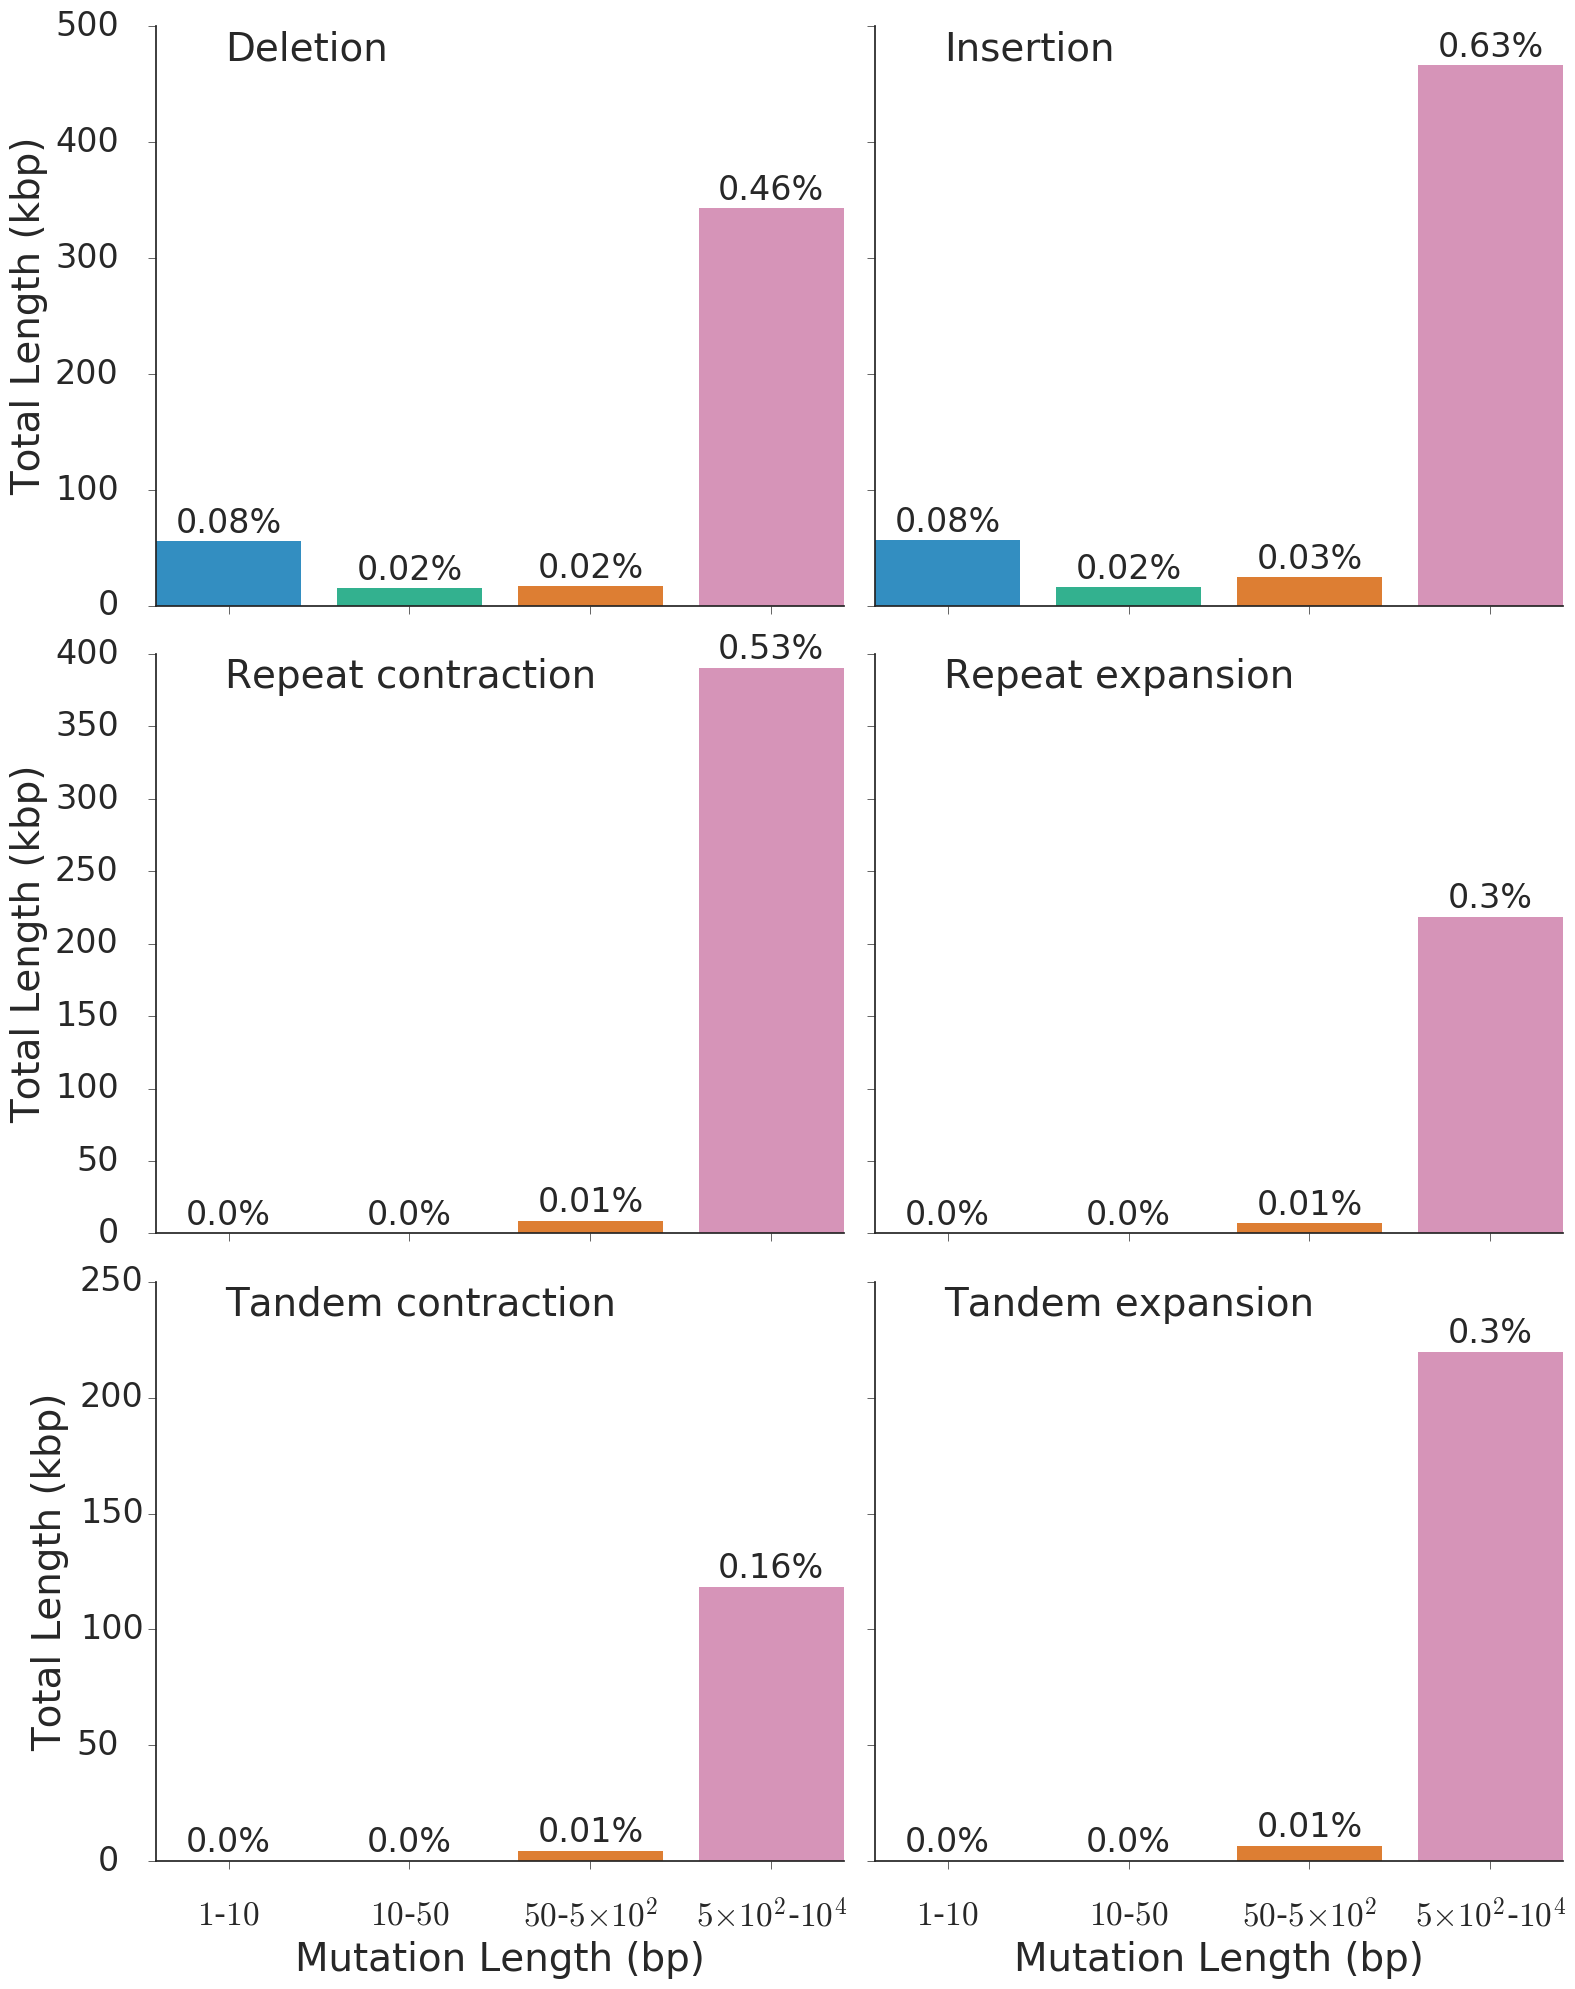

In [24]:
#here get the summary of all Types of variations by size intervals given by Assemblytics
Size_summary_10kb = Assemblytics_summary_df_10kb.sum(level='numbers', axis=1)['Total bp']/1000
index_a = [x.replace(' bp', '') for x in Size_summary_10kb["Insertion"].index]
index_a = list(map(lambda x: labelToScientific(x), index_a))
var_types = Size_summary_10kb.index.levels[0]
#plot
sns.despine(offset=10, trim=True)

#here generate a faced plot for the size variation types
no_subplots = len(var_types)
no_of_subplots_pair = [int(no_subplots/2), 2]
subplot_coordinates = list(product(range(no_of_subplots_pair[0]), range(no_of_subplots_pair[1])))
subplot_coordinates_list = [list(l) for l in subplot_coordinates]
subplot_coordinates_list_rows = [i[0] for i in subplot_coordinates_list]
subplot_coordinates_list_columns = [i[1] for i in subplot_coordinates_list]
fig, ax = plt.subplots(no_of_subplots_pair[0], no_of_subplots_pair[1], figsize=(16,20), sharey='row', sharex='all')
#

#up to here generate what is needed to specificy the plots
ind = np.arange(len(index_a))

TITLE_SIZE = 28
AXIS_LABEL_SIZE = 28
AXIS_TICK_SIZE = 24
BAR_LABEL_SIZE = 24

#function to generate the subplots
def subplots(ax_ind1, ax_ind2, ind, series, name, plotPct=True):
    sns.set_style("ticks")
    sns.despine()
    width = 0.35
    rects = ax[ax_ind1, ax_ind2].bar(ind,series, color=sns.color_palette("colorblind", 6), alpha=0.8, align='center', linewidth=0)
    
    barLabels = []
    for x in range(0, len(series)):
        if plotPct:
            _percentage = (series[x]*1000)/PWH_SIZE*100
            barLabels.append('%s%%' % str(round(_percentage, 2)))
        else:
            barLabels.append(str(int(series[x]*1000)))
    autolabel(rects, barLabels, ax[ax_ind1, ax_ind2], BAR_LABEL_SIZE)
    
    ax[ax_ind1, ax_ind2].set_title(label=name.replace('_', ' '), fontsize = TITLE_SIZE, position=(0.1, 0.93), loc='left')
#    ax[ax_ind1, ax_ind2].set_title(label=stringToScientific('100'), fontsize = TITLE_SIZE, position=(0.1, 0.93), loc='left')
    
    if ax_ind2 == 0:
        ax[ax_ind1, ax_ind2].set_ylabel('Total Length (kbp)', fontsize = AXIS_LABEL_SIZE)
    if ax_ind1 == 2:
        ax[ax_ind1, ax_ind2].set_xlabel('Mutation Length (bp)', fontsize = AXIS_LABEL_SIZE)
        for tick in ax[ax_ind1, ax_ind2].get_xaxis().get_major_ticks():
            tick.set_pad(2*tick.get_pad())
            tick.label1 = tick._get_text1()
    
    ax[ax_ind1, ax_ind2].grid(False, which='Major')
    ax[ax_ind1, ax_ind2].tick_params(axis='both', which='major', labelsize=AXIS_TICK_SIZE, pad=3)
    ax[ax_ind1, ax_ind2].set_xticks(ind)
    ax[ax_ind1, ax_ind2].set_xticklabels(index_a, {'fontsize':AXIS_TICK_SIZE, 'horizontalalignment':'center'})
    ax[ax_ind1, ax_ind2].tick_params(labelsize=AXIS_TICK_SIZE)
    
    for tick in ax[ax_ind1, ax_ind2].yaxis.get_major_ticks():
        tick.label.set_fontsize(AXIS_TICK_SIZE)

for ax_ind1, ax_ind2, _type in zip(subplot_coordinates_list_rows,subplot_coordinates_list_columns, var_types):
    subplots(ax_ind1, ax_ind2, ind, Size_summary_10kb[_type], _type, plotPct=True)
#sns.despine(offset=10, trim=True)
plt.tight_layout()
fig_name = '%s_Assemblytics_summary_df_10kb_v3.type_summary.png' % GENOME
plt.savefig(os.path.join(FIGURE_PATH, fig_name), bbox_inches='tight')

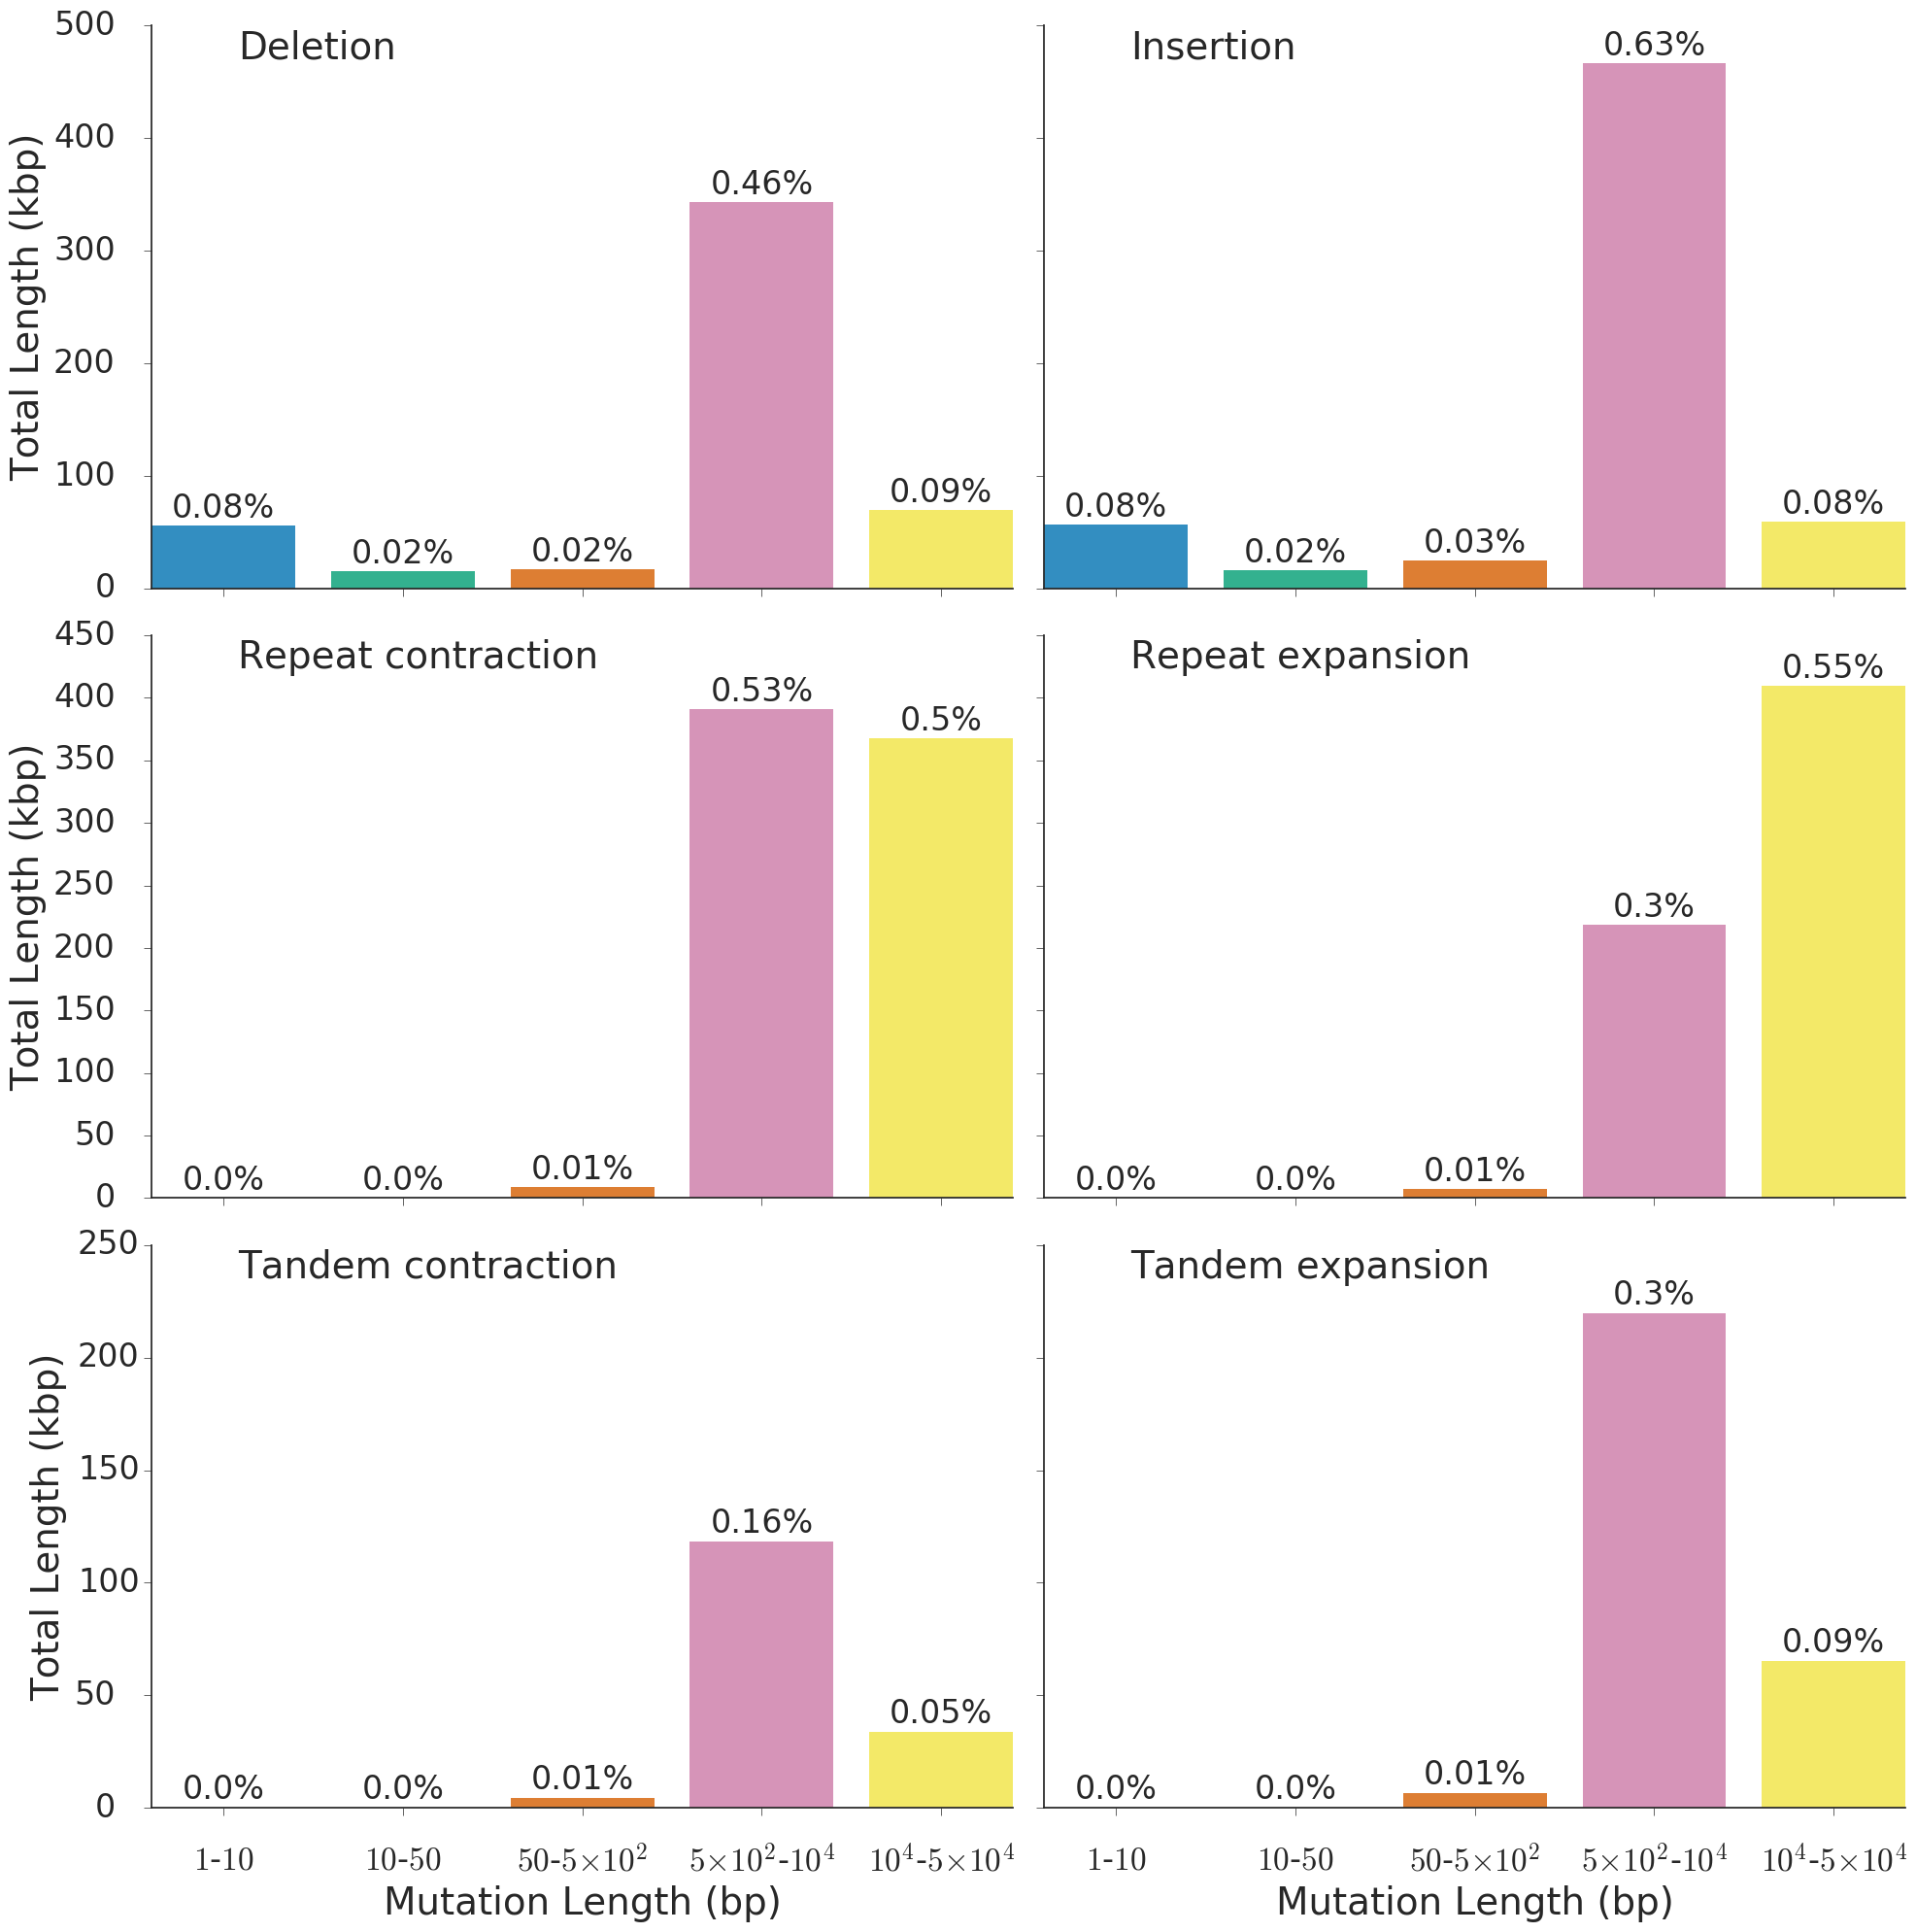

In [17]:
#here get the summary of all Types of variations by size intervals given by Assemblytics
Size_summary_50kb = Assemblytics_summary_df_50kb.sum(level='numbers', axis=1)['Total bp']/1000
index_a = [x.replace(' bp', '') for x in Size_summary_50kb["Insertion"].index]
index_a = list(map(lambda x: labelToScientific(x), index_a))
var_types = Size_summary_50kb.index.levels[0]
#plot
sns.despine(offset=10, trim=True)

#here generate a faced plot for the size variation types
no_subplots = len(var_types)
no_of_subplots_pair = [int(no_subplots/2), 2]
subplot_coordinates = list(product(range(no_of_subplots_pair[0]), range(no_of_subplots_pair[1])))
subplot_coordinates_list = [list(l) for l in subplot_coordinates]
subplot_coordinates_list_rows = [i[0] for i in subplot_coordinates_list]
subplot_coordinates_list_columns = [i[1] for i in subplot_coordinates_list]
fig, ax = plt.subplots(no_of_subplots_pair[0], no_of_subplots_pair[1], figsize=(20,20), sharey='row', sharex='all')

#up to here generate what is needed to specificy the plots
ind = np.arange(len(index_a))

for ax_ind1, ax_ind2, _type in  \
zip(subplot_coordinates_list_rows,subplot_coordinates_list_columns, var_types):
    subplots(ax_ind1, ax_ind2, ind, Size_summary_50kb[_type], _type)
plt.tight_layout()
fig_name = '%s_Assemblytics_summary_df_50kb_v2.type_summary.png' % GENOME
plt.savefig(os.path.join(FIGURE_PATH, fig_name), bbox_inches='tight')

In [18]:
#summarizes here for 10kb

Total_summary_df_10kb = Assemblytics_summary_df_10kb.unstack().sum(level='numbers', axis=1)
Total_summary_df_10kb['variation [1/kbp]'] = Total_summary_df_10kb['Total bp']/PWH_SIZE * 1000
total_relative_var_10kb = Total_summary_df_10kb['Total bp'].sum()/PWH_SIZE*100
print(round(total_relative_var_10kb, 2))

2.66


In [19]:
Total_summary_df_10kb['Total bp'].sum()

1969942

In [20]:
#summarizes here for 50kb

Total_summary_df_50kb = Assemblytics_summary_df_50kb.unstack().sum(level='numbers', axis=1)
Total_summary_df_50kb['variation [1/kbp]'] = Total_summary_df_50kb['Total bp']/PWH_SIZE * 1000
total_relative_var_50kb = Total_summary_df_50kb['Total bp'].sum()/PWH_SIZE*100
print(round(total_relative_var_50kb, 2))

4.02


In [21]:
Total_summary_df_50kb['Total bp'].sum()

2975351

In [22]:
#find the 

In [23]:
Assemblytics_summary_df_10kb.head()

contig_id              pcontig_000          pcontig_001          pcontig_002  \
numbers                      Count Total bp       Count Total bp       Count   
Type      Size range                                                           
Insertion 1-10 bp             3016     3962        1383     1916        2149   
          10-50 bp              52      990          34      494          27   
          50-500 bp              5      602           4      647           6   
          500-10000 bp           7    30780           6    27961           2   
Deletion  1-10 bp             3270     4033        1504     1992        2179   

contig_id                       pcontig_003          pcontig_004           \
numbers                Total bp       Count Total bp       Count Total bp   
Type      Size range                                                        
Insertion 1-10 bp          2647        1591     2045        1713     2296   
          10-50 bp          507          38      688          31      564   
          50-500 bp        1461           5      861           4     1111   
          500-10000 bp    12315           7    31217           8    12125   
Deletion  1-10 bp          2684        2203     2732        1820     2301   

contig_id                ...    pcontig_094          pcontig_095           \
numbers                  ...          Count Total bp       Count Total bp   
Type      Size range     ...                                                
Insertion 1-10 bp        ...              6        6          22       32   
          10-50 bp       ...              1       14           1       19   
          50-500 bp      ...              0        0           0        0   
          500-10000 bp   ...              0        0           0        0   
Deletion  1-10 bp        ...             10       12          18       39   

contig_id              pcontig_101          pcontig_106          pcontig_107  \
numbers                      Count Total bp       Count Total bp       Count   
Type      Size range                                                           
Insertion 1-10 bp               39       45           5        5          31   
          10-50 bp               0        0           0        0           0   
          50-500 bp              0        0           0        0           0   
          500-10000 bp           0        0           0        0           0   
Deletion  1-10 bp               37       42           5        7          53   

contig_id                        
numbers                Total bp  
Type      Size range             
Insertion 1-10 bp            32  
          10-50 bp            0  
          50-500 bp           0  
          500-10000 bp        0  
Deletion  1-10 bp            56  

[5 rows x 170 columns]

For the figure going with this pick the following alignment plots
for example pcontig_28, pcontig_10, pcontig_12, pcontig_02, pcontig_19